In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
 97% 321M/331M [00:00<00:00, 768MB/s]
100% 331M/331M [00:00<00:00, 740MB/s]


In [3]:
import zipfile

In [4]:
# Unzip the file
zip_file = '/content/utkface-new.zip'
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/utkface')

In [7]:
path = Path("/content/utkface/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [8]:
print(len(filenames))
print(filenames[:3])

23708
['82_1_0_20170110184132973.jpg.chip.jpg', '33_1_1_20170114030609784.jpg.chip.jpg', '40_1_2_20170116222648635.jpg.chip.jpg']


# Data preprocessing

In [9]:
np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels,race_labels, image_path = [], [], [], []

for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(temp[0])
    gender_labels.append(temp[1])
    race_labels.append(temp[2])

# From Unstructured data to Structured data

In [10]:
df = pd.DataFrame()
df['image'], df['age'], df['gender'],df['race'] = image_path, age_labels, gender_labels, race_labels

In [11]:
df.head()

,image,age,gender,race
0,50_0_3_20170119205546104.jpg.chip.jpg,50,0,3
1,59_0_0_20170120225040473.jpg.chip.jpg,59,0,0
2,52_1_0_20170104185832638.jpg.chip.jpg,52,1,0
3,39_0_4_20170104000800885.jpg.chip.jpg,39,0,4
4,27_1_3_20170104223211159.jpg.chip.jpg,27,1,3


In [12]:
#remove outliers
df = df[df['race'].isin(['0','1','2','3','4'])]
df['race'].value_counts()

,count
race,
0,10078
1,4526
3,3975
2,3434
4,1692


In [13]:
gender_dict = {0:"Male",1:"Female"}

In [14]:
race_dict = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

In [15]:
df.head()

,image,age,gender,race
0,50_0_3_20170119205546104.jpg.chip.jpg,50,0,3
1,59_0_0_20170120225040473.jpg.chip.jpg,59,0,0
2,52_1_0_20170104185832638.jpg.chip.jpg,52,1,0
3,39_0_4_20170104000800885.jpg.chip.jpg,39,0,4
4,27_1_3_20170104223211159.jpg.chip.jpg,27,1,3


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23705 entries, 0 to 23707
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23705 non-null  object
 1   age     23705 non-null  object
 2   gender  23705 non-null  object
 3   race    23705 non-null  object
dtypes: object(4)
memory usage: 926.0+ KB


In [17]:
df['gender'] = df['gender'].astype('int32')
df['age'] = df['age'].astype('int32')
df['race'] = df['race'].astype('int32')

In [18]:
print(df.dtypes)

image     object
age        int32
gender     int32
race       int32
dtype: object


In [19]:
df.head()

,image,age,gender,race
0,50_0_3_20170119205546104.jpg.chip.jpg,50,0,3
1,59_0_0_20170120225040473.jpg.chip.jpg,59,0,0
2,52_1_0_20170104185832638.jpg.chip.jpg,52,1,0
3,39_0_4_20170104000800885.jpg.chip.jpg,39,0,4
4,27_1_3_20170104223211159.jpg.chip.jpg,27,1,3


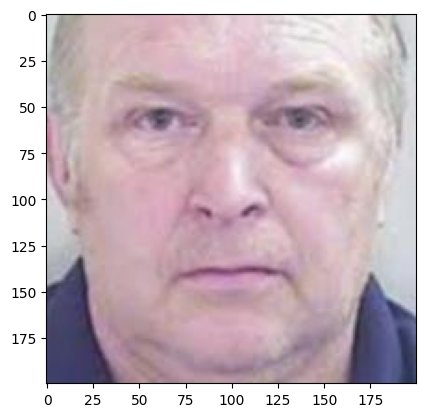

In [20]:
img = Image.open("/content/utkface/UTKFace/"+df['image'][1])
plt.imshow(img)

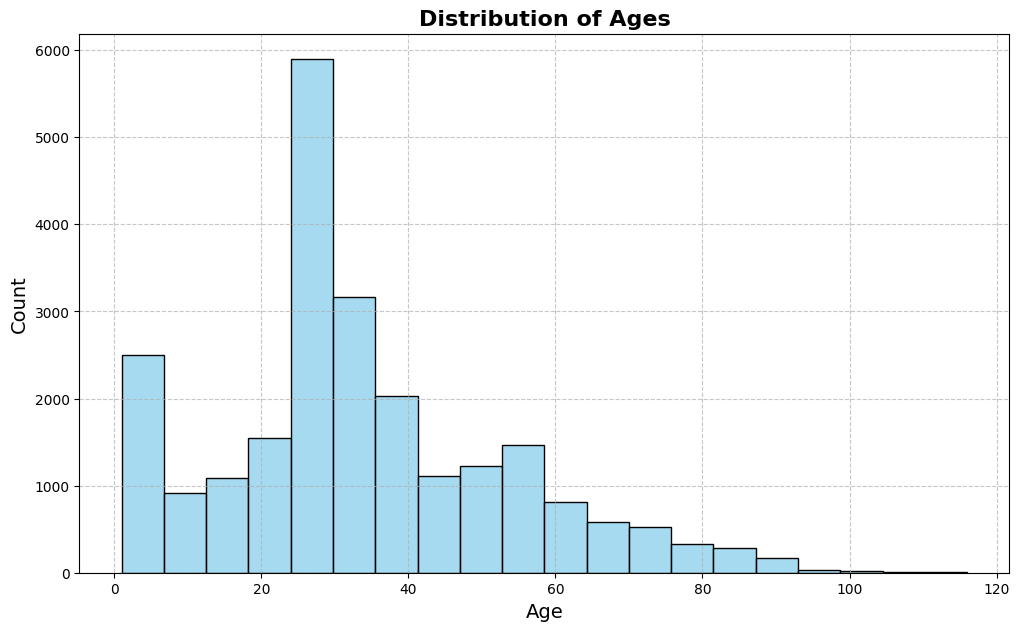

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(12, 7))


sns.histplot(df['age'], bins=20, kde=False, color='skyblue', edgecolor='black')


plt.title('Distribution of Ages', fontsize=16, fontweight='bold')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)


plt.show()

/tmp/ipython-input-22-2409177837.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.age)


<Axes: xlabel='age', ylabel='Density'>

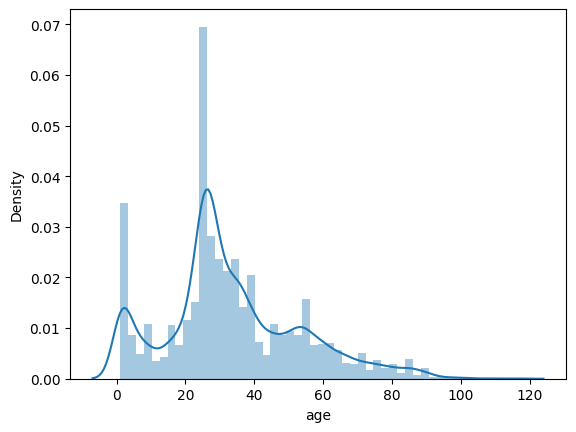

In [22]:
sns.distplot(df.age)

# Plotting Images

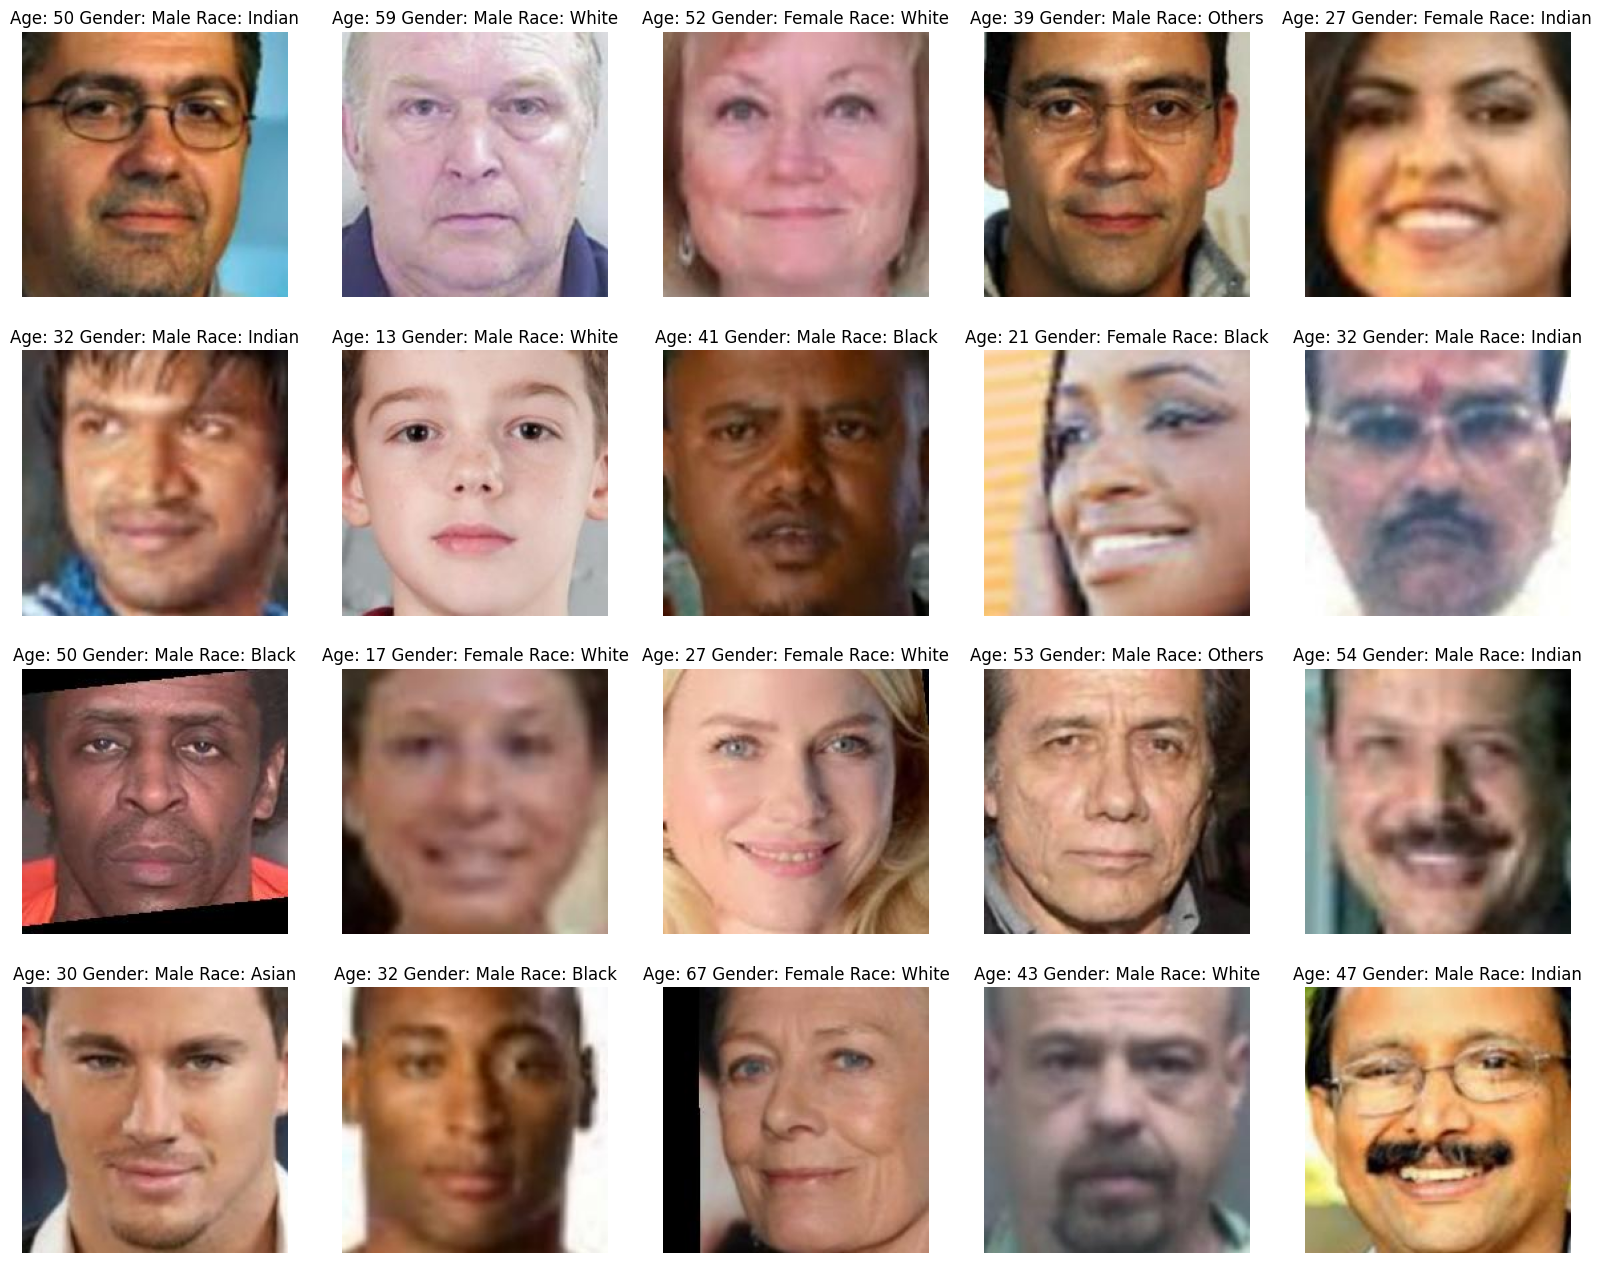

In [23]:
files = df.iloc[0:20]
plt.figure(figsize=(20,20))
for index, file, age, gender, race in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img("/content/utkface/UTKFace/"+file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age} Gender: {gender_dict[gender] } Race: {race_dict[race]}")
    plt.axis('off')

Since dataset is too large, It is taking a lot of time to train the model so I am splitting the data and only using half of the dataset.
I have already shuffled all the data to ensure no biasness in the dataset.

In [24]:
df.count()

,0
image,23705
age,23705
gender,23705
race,23705


In [25]:
train, test = train_test_split(df, train_size=0.8, random_state=42)

In [26]:
train.shape

(18964, 4)

In [27]:
test.shape

(4741, 4)

In [28]:
train.head()

,image,age,gender,race
21098,1_1_4_20161221202050009.jpg.chip.jpg,1,1,4
20881,49_1_0_20170109013409205.jpg.chip.jpg,49,1,0
21548,86_1_2_20170105174652949.jpg.chip.jpg,86,1,2
13630,28_1_0_20170116000542977.jpg.chip.jpg,28,1,0
8226,4_1_4_20161223230058516.jpg.chip.jpg,4,1,4


# Extracting Features

In [29]:
# prompt: here i want data augmentation of images in train. write simple code like this
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)
# test_datagen = ImageDataGenerator(rescale=1./255)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the directory where your training images are located
train_dir = "/content/utkface/UTKFace" # Update this path if necessary

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=train_dir,
    x_col='image',
    y_col=['age', 'gender', 'race'], # Assuming you are predicting age, gender, and race
    target_size=(224, 224), # Choose a target size for your images
    batch_size=32,
    class_mode='multi_output' # Use 'multi_output' for multiple predictions
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=train_dir, # Assuming test images are in the same directory
    x_col='image',
    y_col=['age', 'gender', 'race'],
    target_size=(224, 224),
    batch_size=32,
    class_mode='multi_output'
)

Found 18964 validated image filenames.
Found 4741 validated image filenames.


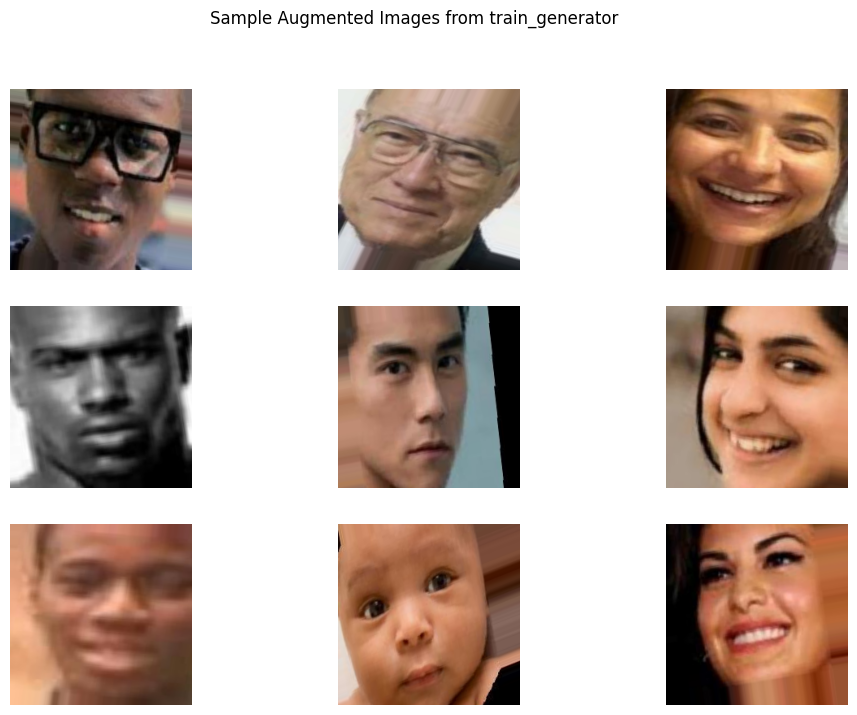

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and labels from the generator
images, labels = next(train_generator)

# images is a batch of augmented images, shape: (batch_size, 224, 224, 3)
# labels correspond to age, gender, race for each image

# Plot a grid of augmented images
plt.figure(figsize=(12, 8))
for i in range(9):  # show 9 images
    plt.subplot(3, 3, i + 1)
    img = images[i]
    plt.imshow(img)
    plt.axis('off')

plt.suptitle("Sample Augmented Images from train_generator")
plt.show()

In [31]:
#converting Image to numpy array (extracting feature)
x_train = []
for file in train.image:
    img = load_img("/content/utkface/UTKFace/"+file).convert('RGB')
    img = img.resize((224, 224))
    img = np.array(img)
    x_train.append(img)

x_train = np.array(x_train)

x_train = x_train.reshape(len(x_train), 224, 224, 3)

In [32]:
x_train

array([[[[ 55,  32,  18],
         [ 57,  34,  20],
         [ 58,  35,  21],
         ...,
         [137, 108, 102],
         [129, 100,  92],
         [124,  95,  87]],

        [[ 55,  32,  18],
         [ 57,  34,  20],
         [ 58,  35,  21],
         ...,
         [134, 105,  99],
         [127,  98,  90],
         [123,  94,  86]],

        [[ 55,  32,  18],
         [ 56,  33,  19],
         [ 58,  35,  21],
         ...,
         [127,  98,  92],
         [122,  93,  85],
         [120,  91,  83]],

        ...,

        [[130,  80,  83],
         [131,  81,  84],
         [133,  83,  86],
         ...,
         [194, 151, 165],
         [188, 143, 158],
         [181, 139, 153]],

        [[122,  72,  73],
         [124,  74,  74],
         [125,  75,  76],
         ...,
         [189, 145, 160],
         [184, 137, 153],
         [177, 133, 148]],

        [[115,  65,  66],
         [117,  67,  68],
         [119,  69,  70],
         ...,
         [188, 141, 157],
        

In [33]:
x_train.shape

(18964, 224, 224, 3)

# Normalizing data

In [34]:
# x_train = x_train/255

In [35]:
y_gender = np.array(train.gender)
y_age = np.array(train.age)
y_race = np.array(train.race)

In [36]:
y_gender

array([1, 1, 1, ..., 1, 1, 0], dtype=int32)

In [37]:
y_age

array([ 1, 49, 86, ..., 24, 26, 32], dtype=int32)

In [38]:
y_race

array([4, 0, 2, ..., 2, 3, 3], dtype=int32)

In [39]:
from tensorflow.keras.utils import to_categorical

y_race = to_categorical(y_race, num_classes=5)

In [40]:
y_race

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

# Creating model

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.initializers import glorot_uniform


In [ ]:
# # Load the VGG16 model
# conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Freeze the VGG16 layers
# for layer in conv_base.layers:
#     layer.trainable = False

# # Input layer
# input_size = (224, 224, 3)
# inputs = Input(input_size)

# # Apply the VGG16 base model
# X = conv_base(inputs)

# # Flatten the output
# X = Flatten()(X)

# # Dense layers for shared representation
# dense_1 = Dense(256, activation='relu')(X)
# dropout_1 = Dropout(0.4)(dense_1)

# # Dense layers specific to each task
# dense_2 = Dense(256, activation='relu')(X)
# dropout_2 = Dropout(0.4)(dense_2)

# dense_3 = Dense(128, activation='relu')(X)
# dropout_3 = Dropout(0.4)(dense_3)

# # Output layers
# output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)  # Gender output
# output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)      # Age output
# output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)    # Race output

# model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

# model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,211,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race_output (Dense) │ (None, 5)         │        645 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 16,058,119 (61.26 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# from tensorflow.keras.applications import VGG16
# from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
# from tensorflow.keras.models import Model

# # Load VGG16 base model (without the top FC layers)
# conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Make entire model trainable initially
# conv_base.trainable = True

# # Freeze all layers except those in block5
# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'block5_conv1':
#         set_trainable = True
#     layer.trainable = set_trainable  # Only block5_conv1 and layers after it will be trainable

# # Check which layers are trainable (optional debug print)
# for layer in conv_base.layers:
#     print(layer.name, layer.trainable)

# # Input layer
# input_size = (224, 224, 3)
# inputs = Input(input_size)

# # Pass input through VGG16 base
# X = conv_base(inputs)

# # Flatten the output from VGG16
# X = Flatten()(X)

# # Shared dense layer for gender
# dense_1 = Dense(256, activation='relu')(X)
# dropout_1 = Dropout(0.2)(dense_1)

# # Shared dense layer for age
# dense_2 = Dense(256, activation='relu')(X)
# dropout_2 = Dropout(0.2)(dense_2)

# # Shared dense layer for race
# dense_3 = Dense(128, activation='relu')(X)
# dropout_3 = Dropout(0.2)(dense_3)

# # Output layers
# output_1 = Dense(1, activation='sigmoid', name='gender_output')(dropout_1)   # Binary (0 or 1)
# output_2 = Dense(1, activation='linear', name='age_output')(dropout_2)       # Regression
# output_3 = Dense(5, activation='softmax', name='race_output')(dropout_3)     # Multi-class classification

# # Build the final model
# model = Model(inputs=inputs, outputs=[output_1, output_2, output_3])

# # Show model architecture
# model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
input_layer False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 7, 7, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 25088)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  6,422,784 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │  3,211,392 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race_output (Dense) │ (None, 5)         │        645 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,772,807 (117.39 MB)

 Trainable params: 23,137,543 (88.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model

# Load ResNet50 base model (excluding top fully connected layers)
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initially make all layers non-trainable
conv_base.trainable = True

# Freeze all layers except from 'conv5_block1_out' onwards (last block)
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block1_out':
        set_trainable = True
    layer.trainable = set_trainable

# Optional: Print trainable layers for debugging
for layer in conv_base.layers:
    print(layer.name, layer.trainable)

# Input layer
input_size = (224, 224, 3)
inputs = Input(input_size)

# Pass input through ResNet50 base
X = conv_base(inputs)

# Global Average Pooling instead of Flatten (recommended for ResNet)
X = GlobalAveragePooling2D()(X)

# Dense layers for each output branch

# Gender branch
dense_gender = Dense(256)(X)
bn_gender = BatchNormalization()(dense_gender)
act_gender = Activation('relu')(bn_gender)
dropout_gender = Dropout(0.1)(act_gender)
output_gender = Dense(1, activation='sigmoid', name='gender_output')(dropout_gender)

# Age branch
dense_age = Dense(256)(X)
bn_age = BatchNormalization()(dense_age)
act_age = Activation('relu')(bn_age)
dropout_age = Dropout(0.1)(act_age)
output_age = Dense(1, activation='linear', name='age_output')(dropout_age)

# Race branch
dense_race = Dense(256)(X)
bn_race = BatchNormalization()(dense_race)
act_race = Activation('relu')(bn_race)
dropout_race = Dropout(0.1)(act_race)
output_race = Dense(5, activation='softmax', name='race_output')(dropout_race)

# Final model
model = Model(inputs=inputs, outputs=[output_gender, output_age, output_race])

# Show model architecture
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
input_layer False
conv1_pad False
conv1_conv False
conv1_bn False
conv1_relu False
pool1_pad False
pool1_pool False
conv2_block1_1_conv False
conv2_block1_1_bn False
conv2_block1_1_relu False
conv2_block1_2_conv False
conv2_block1_2_bn False
conv2_block1_2_relu False
conv2_block1_0_conv False
conv2_block1_3_conv False
conv2_block1_0_bn False
conv2_block1_3_bn False
conv2_block1_add False
conv2_block1_out False
conv2_block2_1_conv False
conv2_block2_1_bn False
conv2_block2_1_relu False
conv2_block2_2_conv False
conv2_block2_2_bn False
conv2_block2_2_relu False
conv2_block2_3_conv False
conv2_block2_3_bn False
conv2_block2_add False
conv2_block2_out False
conv2_block3_1_conv False
conv2_block3_1_bn False
conv2_block3_1_relu False
conv2_block3_2_conv False
conv2_block3_2_bn False
conv2_block3_2_relu False
conv2_block3_3_conv False
conv2_block3_3_bn False
conv2_block3_add False
conv2_block3_out False
conv3_block1_1_conv False
conv3_block1_

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_output       │ (None, 1)         │        257 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_output (Dense)  │ (None, 1)         │        257 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ race_output (Dense) │ (None, 5)         │      1,285 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 25,166,215 (96.00 MB)

 Trainable params: 10,508,295 (40.09 MB)

 Non-trainable params: 14,657,920 (55.92 MB)

In [41]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model

# Load ResNet50 base model (excluding top fully connected layers)
conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Initially make all layers non-trainable
conv_base.trainable = True

# Freeze all layers except from 'conv5_block1_out' onwards (last block)
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block1_out':
        set_trainable = True
    layer.trainable = set_trainable

# Input layer
input_size = (224, 224, 3)
inputs = Input(input_size)

# Pass input through ResNet50 base
X = conv_base(inputs)

# Global Max Pooling instead of Flatten (recommended for ResNet)
X = GlobalMaxPooling2D()(X)

# ========================
# Gender branch
# ========================
x_gender = Dense(128)(X)
x_gender = BatchNormalization()(x_gender)
x_gender = Activation('relu')(x_gender)
x_gender = Dropout(0.3)(x_gender)

# Additional Dense layer
x_gender = Dense(64)(x_gender)
x_gender = BatchNormalization()(x_gender)
x_gender = Activation('relu')(x_gender)
x_gender = Dropout(0.2)(x_gender)

x_gender = Dense(32)(x_gender)
x_gender = BatchNormalization()(x_gender)
x_gender = Activation('relu')(x_gender)
x_gender = Dropout(0.1)(x_gender)

x_gender = Dense(16)(x_gender)
x_gender = BatchNormalization()(x_gender)
x_gender = Activation('relu')(x_gender)
x_gender = Dropout(0.1)(x_gender)

output_gender = Dense(1, activation='sigmoid', name='gender_output')(x_gender)

# ========================
# Age branch
# ========================
x_age = Dense(128)(X)
x_age = BatchNormalization()(x_age)
x_age = Activation('relu')(x_age)
x_age = Dropout(0.3)(x_age)

# Additional Dense layer
x_age = Dense(64)(x_age)
x_age = BatchNormalization()(x_age)
x_age = Activation('relu')(x_age)
x_age = Dropout(0.2)(x_age)

x_age = Dense(32)(x_age)
x_age = BatchNormalization()(x_age)
x_age = Activation('relu')(x_age)
x_age = Dropout(0.1)(x_age)

x_age = Dense(16)(x_age)
x_age = BatchNormalization()(x_age)
x_age = Activation('relu')(x_age)
x_age = Dropout(0.1)(x_age)

output_age = Dense(1, activation='linear', name='age_output')(x_age)

# ========================
# Race branch
# ========================
x_race = Dense(128)(X)
x_race = BatchNormalization()(x_race)
x_race = Activation('relu')(x_race)
x_race = Dropout(0.3)(x_race)

# Additional Dense layer
x_race = Dense(64)(x_race)
x_race = BatchNormalization()(x_race)
x_race = Activation('relu')(x_race)
x_race = Dropout(0.2)(x_race)

x_race = Dense(32)(x_race)
x_race = BatchNormalization()(x_race)
x_race = Activation('relu')(x_race)
x_race = Dropout(0.1)(x_race)

x_race = Dense(16)(x_race)
x_race = BatchNormalization()(x_race)
x_race = Activation('relu')(x_race)
x_race = Dropout(0.1)(x_race)

output_race = Dense(5, activation='softmax', name='race_output')(x_race)

# ========================
# Final model
# ========================
model = Model(inputs=inputs, outputs=[output_gender, output_age, output_race])

# Show model architecture
model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    262,272 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    262,272 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_5[0][0]   

 Total params: 24,410,119 (93.12 MB)

 Trainable params: 9,752,295 (37.20 MB)

 Non-trainable params: 14,657,824 (55.92 MB)

In [43]:
# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer= Adam(),
    loss={
        'gender_output': 'binary_crossentropy',
        'age_output': 'mean_squared_error',
        'race_output': 'categorical_crossentropy'
    },
    metrics={
        'gender_output': 'accuracy',
        'age_output': 'mean_absolute_error',
        'race_output': 'accuracy'
    }
)

In [44]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_1[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │    262,272 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │    262,272 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_4[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 64)        │      8,256 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_5[0][0]   

 Total params: 24,410,119 (93.12 MB)

 Trainable params: 9,752,295 (37.20 MB)

 Non-trainable params: 14,657,824 (55.92 MB)

# Training the model

In [45]:
y_race

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

In [ ]:
# from tensorflow.keras.callbacks import ModelCheckpoint

# # Define the checkpoint callback to save the model with the best 'race_output' performance
# checkpoint = ModelCheckpoint(
#     'best_model_by_race_output.keras',  # Path where the best model will be saved
#     monitor='val_race_output_loss',  # Metric to monitor
#     save_best_only=True,  # Save only the best model
#     mode='min',  # Mode for the metric: 'min' for loss
#     verbose=1  # Verbosity level
# )

# # Train the model with the checkpoint callback
# history = model.fit(
#     x_train,
#     {
#         'gender_output': y_gender,
#         'age_output': y_age,
#         'race_output': y_race
#     },
#     epochs=20,  # Set the number of epochs as needed
#     batch_size=32,  # Set the batch size as needed
#     validation_split=0.1,  # Use a validation split or provide validation data
#     callbacks=[checkpoint]  # Add the checkpoint callback
# )

Epoch 1/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - age_output_loss: 145336.8906 - age_output_mean_absolute_error: 62.2157 - gender_output_accuracy: 0.5098 - gender_output_loss: 12.7704 - loss: 145357.8281 - race_output_accuracy: 0.3530 - race_output_loss: 8.1055
Epoch 1: val_race_output_loss improved from inf to 1.42475, saving model to best_model_by_race_output.keras
534/534 ━━━━━━━━━━━━━━━━━━━━ 162s 263ms/step - age_output_loss: 145112.5469 - age_output_mean_absolute_error: 62.1433 - gender_output_accuracy: 0.5098 - gender_output_loss: 12.7537 - loss: 145133.5156 - race_output_accuracy: 0.3531 - race_output_loss: 8.0962 - val_age_output_loss: 254.0894 - val_age_output_mean_absolute_error: 12.0021 - val_gender_output_accuracy: 0.5161 - val_gender_output_loss: 0.6884 - val_loss: 258.1228 - val_race_output_accuracy: 0.4302 - val_race_output_loss: 1.4247
Epoch 2/20
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - age_output_loss: 270.1345 - age_output_mean_absolute_error: 12.5838 - gend

In [46]:
# Checkpoint: Save best model based on overall validation loss
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model_all_outputs.keras',
    monitor='val_loss',         # Monitor total validation loss
    save_best_only=True,
    mode='min',
    verbose=1
)

# Fit the model
history = model.fit(
    x_train,
    {
        'gender_output': y_gender,
        'age_output': y_age,
        'race_output': y_race
    },
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[checkpoint]
)

Epoch 1/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - age_output_loss: 1445.5623 - age_output_mean_absolute_error: 33.1551 - gender_output_accuracy: 0.7409 - gender_output_loss: 0.5075 - loss: 1447.4668 - race_output_accuracy: 0.4362 - race_output_loss: 1.3957
Epoch 1: val_loss improved from inf to 893.20844, saving model to best_model_all_outputs.keras
534/534 ━━━━━━━━━━━━━━━━━━━━ 125s 162ms/step - age_output_loss: 1445.3705 - age_output_mean_absolute_error: 33.1528 - gender_output_accuracy: 0.7410 - gender_output_loss: 0.5074 - loss: 1447.2758 - race_output_accuracy: 0.4363 - race_output_loss: 1.3954 - val_age_output_loss: 893.2703 - val_age_output_mean_absolute_error: 25.8578 - val_gender_output_accuracy: 0.7770 - val_gender_output_loss: 0.5064 - val_loss: 893.2084 - val_race_output_accuracy: 0.5841 - val_race_output_loss: 1.1197
Epoch 2/50
534/534 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - age_output_loss: 927.7087 - age_output_mean_absolute_error: 26.1848 - gender_output_accuracy: 0.8

# Predicting test image

In [47]:
race_dict

{0: 'White', 1: 'Black', 2: 'Asian', 3: 'Indian', 4: 'Others'}

In [48]:
import numpy

In [49]:
print(np.argmax(y_race[index]))

1


Original: Gender =  Female  Age =  26  Race =  Asian
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Prediction: Gender =  Female  Age =  27  Race =  Asian


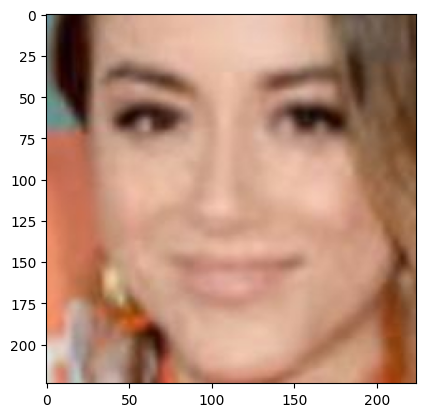

In [50]:
index=100
print("Original: Gender = ", gender_dict[y_gender[index]]," Age = ", y_age[index]," Race = ", race_dict[np.argmax(y_race[index])])

pred = model.predict(x_train[index].reshape(1, 224, 224, 3))
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_race = race_dict[round(np.argmax(pred[2][0]))]

print("Prediction: Gender = ", pred_gender," Age = ", pred_age," Race = ", pred_race)
plt.imshow(x_train[index].reshape(224, 224, 3))

In [51]:
test.head()

,image,age,gender,race
17816,25_1_1_20170112205154091.jpg.chip.jpg,25,1,1
15082,35_1_0_20170117185227543.jpg.chip.jpg,35,1,0
22832,26_1_2_20170116180305369.jpg.chip.jpg,26,1,2
16076,53_1_0_20170110160643251.jpg.chip.jpg,53,1,0
8973,1_1_4_20170103204831032.jpg.chip.jpg,1,1,4


In [52]:
#converting Image to numpy array (extracting feature)
x_test = []
for file in test.image:
    img = load_img("/content/utkface/UTKFace/" + file)

    # Resize the image using the correct resampling method
    img = img.resize((224, 224), Image.LANCZOS)

    # Convert the image to a NumPy array
    img = np.array(img)
    x_test.append(img)

# Convert the list of images to a NumPy array
x_test = np.array(x_test)

In [53]:
#converting labels
y_gender_test = test['gender'].values
y_age_test = test['age'].values
y_race_test = test['race'].values
y_race_test = to_categorical(y_race_test, num_classes=5)

In [54]:
test_acc = model.evaluate(x_test, {'gender_output': y_gender_test, 'age_output': y_age_test, 'race_output': y_race_test}, verbose=0)

In [55]:
print('total loss:', test_acc[0])
print('gender loss:', test_acc[1])
print('age loss:', test_acc[2])
print('race loss:', test_acc[3])

total loss: 70.33246612548828
gender loss: 0.4310002028942108
age loss: 68.54940795898438
race loss: 1.1098326444625854


In [56]:
x_test.shape

(4741, 224, 224, 3)

In [57]:
pred = model.predict(x_test)

149/149 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step


In [58]:
pred[2][0]

array([2.7010410e-06, 9.9997747e-01, 3.8734481e-08, 1.9569487e-05,
       2.7422644e-07], dtype=float32)

In [59]:
pred_gender = []
for i in pred[0]:
    pred_gender.append(gender_dict[round(i[0])])

pred_age = []
for i in pred[1]:
    pred_age.append(round(i[0]))

pred_race = []
for i in pred[2]:
    pred_race.append(race_dict[round(np.argmax(i))])

In [60]:
#pred to df
df_pred = pd.DataFrame({'gender': pred_gender, 'age': pred_age, 'race': pred_race})

In [61]:
df_pred['gender'].value_counts()

,count
gender,
Male,2732
Female,2009


In [62]:
df_pred['age'].value_counts()

,count
age,
3,354
29,234
27,206
24,202
30,188
...,...
84,1
92,1
81,1


In [63]:
df_pred['race'].value_counts()

,count
race,
White,2142
Black,1034
Indian,829
Asian,558
Others,178


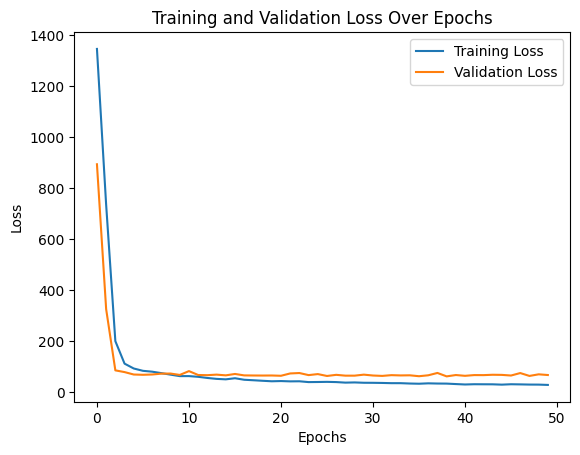

In [64]:
import matplotlib.pyplot as plt

# Assuming your training history is saved in `history`
# and it contains keys 'loss' and 'val_loss' for train and validation losses

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


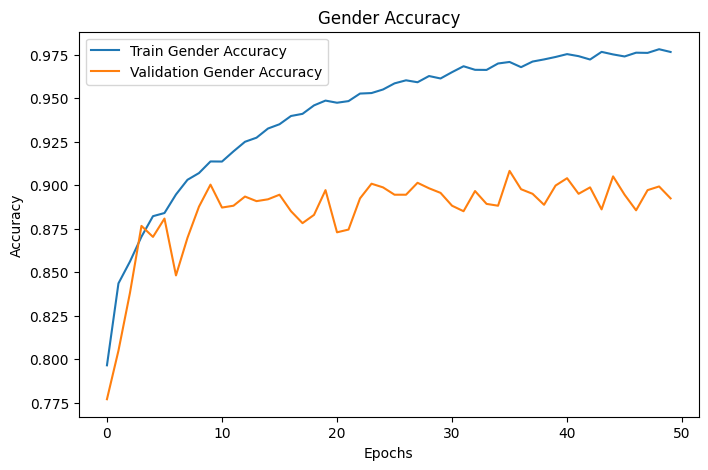

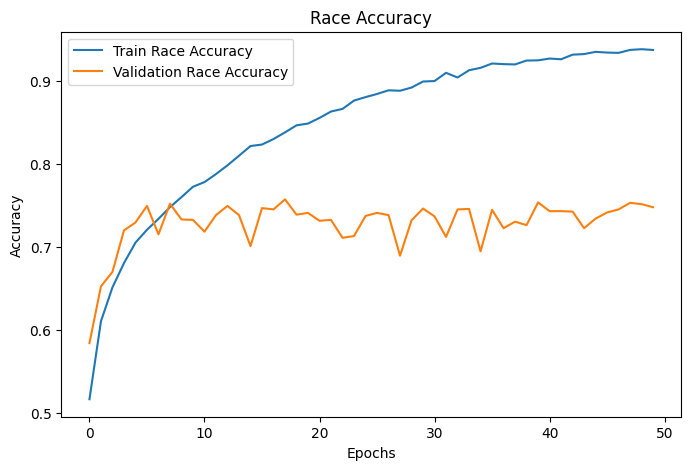

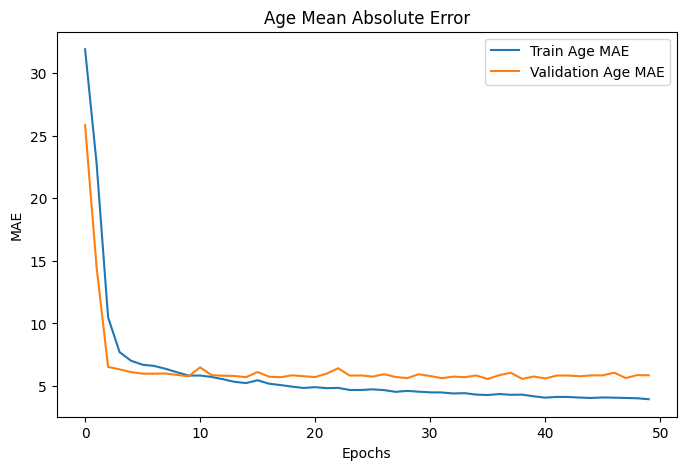

In [65]:
import matplotlib.pyplot as plt

# Define epochs
epochs = range(len(history.history['loss']))

# Plot Gender Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['gender_output_accuracy'], label='Train Gender Accuracy')
plt.plot(epochs, history.history['val_gender_output_accuracy'], label='Validation Gender Accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Race Accuracy
plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['race_output_accuracy'], label='Train Race Accuracy')
plt.plot(epochs, history.history['val_race_output_accuracy'], label='Validation Race Accuracy')
plt.title('Race Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Age MAE
plt.figure(figsize=(8, 5))
plt.plot(epochs, history.history['age_output_mean_absolute_error'], label='Train Age MAE')
plt.plot(epochs, history.history['val_age_output_mean_absolute_error'], label='Validation Age MAE')
plt.title('Age Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Predicted Gender: Female
Predicted Age: 16
Predicted Race: White


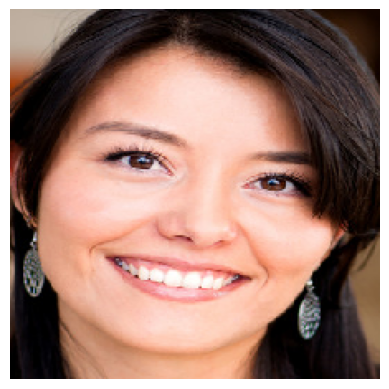

In [80]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

# Replace with your actual image path
image_path = '/content/woman.jpg'

# Load and resize image to (224, 224)
img = load_img(image_path, target_size=(224, 224))

# Convert to array and preprocess for ResNet50
img_array = np.array(img)
img_array = preprocess_input(img_array)

# Add batch dimension (1, 224, 224, 3)
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
pred = model.predict(img_array)

# Decode predictions
pred_gender = gender_dict[round(pred[0][0][0])]
pred_age = round(pred[1][0][0])
pred_race = race_dict[np.argmax(pred[2][0])]

# Print predictions
print(f"Predicted Gender: {pred_gender}")
print(f"Predicted Age: {pred_age}")
print(f"Predicted Race: {pred_race}")

# Show the image
plt.imshow(img)
plt.axis('off')
plt.show()
